### Import Required Libraries

In [3]:
# common libraries
import pandas as pd # data manipulation and extraction
import numpy as np # numerical computation
import matplotlib.pyplot as plt # data visualization
import seaborn as sns # data visualization
import warnings # ignore warnings

# preprocessing libraries
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder,label_binarize
from fast_ml.model_development import train_valid_test_split

# classifcation model and model selection libraries
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit 

# model evaluation libraries
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score, roc_auc_score, roc_curve, ConfusionMatrixDisplay
from itertools import cycle

# model inspection libraries
import shap
from scipy.interpolate import interp1d



### Read in the data

In [4]:
data = pd.read_csv('../notebooks/data/merged_inputed_data.csv')

print(f'Shape of dataframe: {data.shape}')
print('\n')

data.head()

Shape of dataframe: (1305, 358)




,patdeid,meds_methadone_0,meds_buprenorphine_0,meds_methadone_1,meds_buprenorphine_1,meds_methadone_2,meds_buprenorphine_2,meds_methadone_3,meds_buprenorphine_3,meds_methadone_4,...,race_amer_ind,race_Asian,race_Black,race_pacific_isl,race_White,medication,total_visits,TNT,CNT,responder
0,1,0.0,8.0,0.0,160.0,0.0,320.0,0.0,192.0,0.0,...,0.0,0.0,0.0,0.0,1.0,2.0,26,20,8,1
1,2,0.0,8.0,0.0,48.0,0.0,48.0,0.0,60.0,0.0,...,0.0,0.0,0.0,0.0,1.0,2.0,26,6,4,0
2,3,30.0,0.0,170.0,0.0,310.0,0.0,420.0,0.0,360.0,...,0.0,0.0,0.0,0.0,1.0,1.0,26,0,0,0
3,4,0.0,16.0,0.0,152.0,0.0,192.0,0.0,160.0,0.0,...,0.0,0.0,0.0,0.0,1.0,2.0,26,4,1,0
4,6,0.0,16.0,0.0,8.0,0.0,8.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,2.0,3,0,0,0


## Remove Features to prevent data leakage
The opiate tests and self reported use for the final month of treatment are removed to prevent data leakage

### Split the data into training, testing and validation sets

In [6]:
# define parameters
train_size = 0.7
valid_size = 0.1
test_size = 0.2

# split data
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(data, target = 'responder', 
                                                                            train_size=train_size, valid_size=valid_size, test_size=test_size)

# print shapes of dataframes
print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of y_train: {y_train.shape}')
print('\n')
print(f'Shape of X_valid: {X_valid.shape}')
print(f'Shape of y_valid: {y_valid.shape}')
print('\n')
print(f'Shape of X_test: {X_test.shape}')
print(f'Shape of y_test: {y_test.shape}')


Shape of X_train: (913, 342)
Shape of y_train: (913,)


Shape of X_valid: (130, 342)
Shape of y_valid: (130,)


Shape of X_test: (262, 342)
Shape of y_test: (262,)


In [7]:
 # use label encoder to encode labels for y_train, y_test and y_val
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_valid)

### Fit the model

In [8]:
def fit_model(X_train, y_train):
    parameters = [
        {'n_estimators':[150,200,300], 'learning_rate':[0.1,0.01,0.001]}
    ]

    grid_search = GridSearchCV(XGBClassifier(), 
                               parameters,
                               verbose=True, 
                               scoring='f1', 
                               cv=StratifiedShuffleSplit(n_splits=5),
                               n_jobs=8)
    grid_search.fit(X_train, y_train)
    
    return grid_search

In [9]:
grid_search = fit_model(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


In [10]:
# print best score and best params from grid search
print(f'Best score: {grid_search.best_score_}')
print('\n')
print(f'Best params: {grid_search.best_params_}')
print('\n')
print(f'Accuracy score for training set: {grid_search.score(X_train, y_train)})')

Best score: 0.7544019138755982


Best params: {'learning_rate': 0.1, 'n_estimators': 150}


Accuracy score for training set: 1.0)


In [11]:
# refit model with best params
xgb = XGBClassifier(learning_rate=0.1, n_estimators=300)

# fit model
xgb.fit(X_train, y_train,eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric=["auc","error"], verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

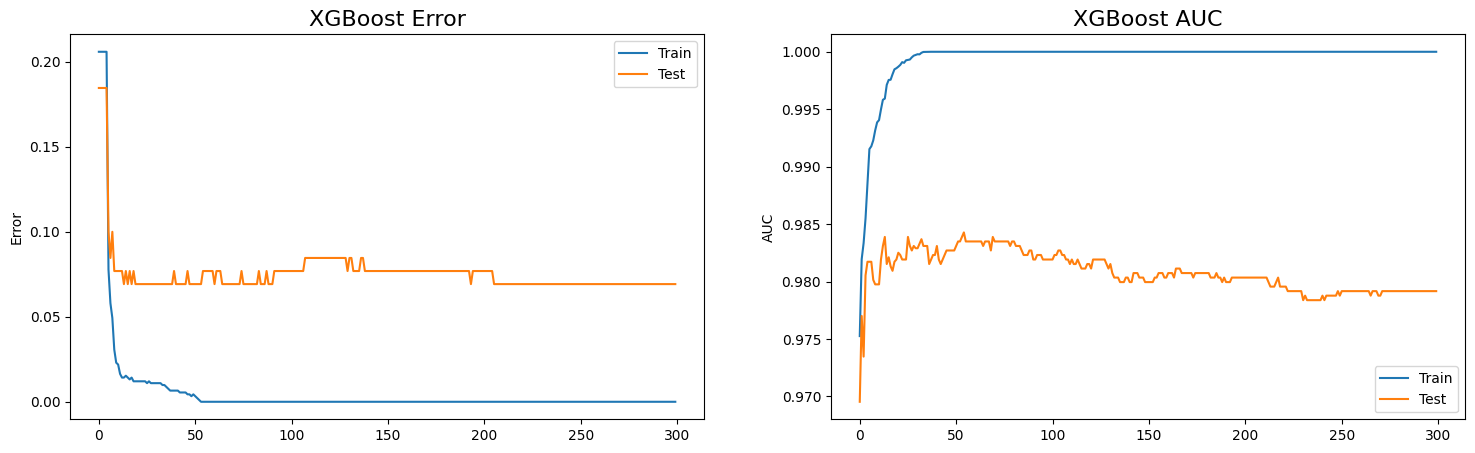

In [12]:
# retrieve performance metrics
results = xgb.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)

# plot log loss and classification error 
fig, axs = plt.subplots(ncols=2, figsize=(18, 5))

# plot log loss
axs[0].plot(x_axis, results['validation_0']['error'], label='Train')
axs[0].plot(x_axis, results['validation_1']['error'], label='Test')
axs[0].legend()
axs[0].set_ylabel('Error')
axs[0].set_title('XGBoost Error', fontsize=16)

# plot classification error
axs[1].plot(x_axis, results['validation_0']['auc'], label='Train')
axs[1].plot(x_axis, results['validation_1']['auc'], label='Test')
axs[1].legend()
axs[1].set_ylabel('AUC')
axs[1].set_title('XGBoost AUC', fontsize=16)

plt.show()


### Evaluate the fitted model

In [13]:
y_pred_train = xgb.predict(X_train)
y_pred_val = xgb.predict(X_valid)
y_pred_test = grid_search.predict(X_test)

y_train_prob = xgb.predict_proba(X_train)
y_val_prob = xgb.predict_proba(X_valid)
y_test_prob = xgb.predict_proba(X_test)

In [14]:
print(classification_report(y_valid,y_pred_val))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       106
           1       0.89      0.71      0.79        24

    accuracy                           0.93       130
   macro avg       0.92      0.84      0.87       130
weighted avg       0.93      0.93      0.93       130



In [15]:
print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       197
           1       0.86      0.85      0.85        65

    accuracy                           0.93       262
   macro avg       0.90      0.90      0.90       262
weighted avg       0.93      0.93      0.93       262



In [16]:
print(classification_report(y_train,y_pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       725
           1       1.00      1.00      1.00       188

    accuracy                           1.00       913
   macro avg       1.00      1.00      1.00       913
weighted avg       1.00      1.00      1.00       913



In [17]:
# Measure F1 score for training, validation and testing
print('Train Accuracy: %0.3f' % accuracy_score(y_train,y_pred_train))
print('Validation Accuracy: %0.3f' % accuracy_score(y_val,y_pred_val))
print('Test Accuracy: %0.3f' % accuracy_score(y_test,y_pred_test))

Train Accuracy: 1.000
Validation Accuracy: 0.931
Test Accuracy: 0.927


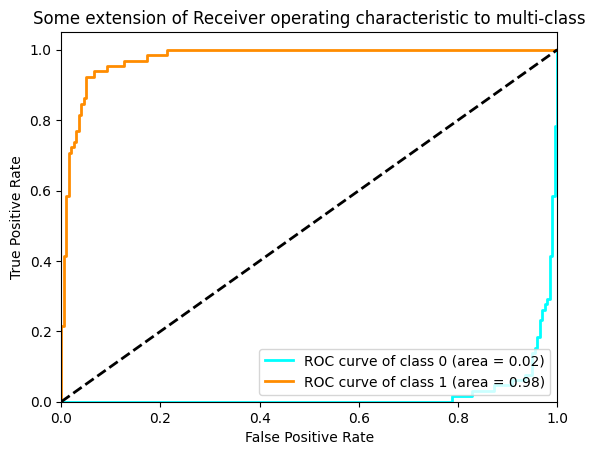

In [18]:
# Plot all ROC curves

#Calculate ROC curve and ROC each class
fpr = dict()
tpr = dict()
roc_auc = dict()
y_bin = label_binarize(y_test, classes=[0,1])
n_classes =2

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_test_prob[:,i])
    roc_auc[i] = roc_auc_score(y_test, y_test_prob[:,i])
plt.figure()
lw=2
colors = cycle(['aqua', 'darkorange']) #, 'cornflowerblue' ]) #'deeppink','navy'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(le.classes_[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

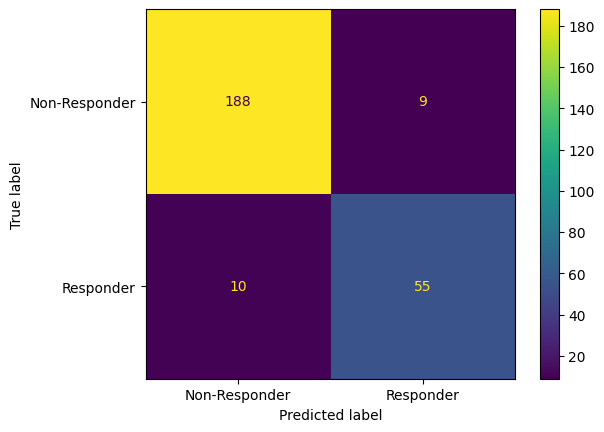

In [19]:
# plot confusion matrix for test set
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Responder', 'Responder'])
disp.plot();

In [20]:
ex = shap.Explainer(xgb.predict_proba, X_train, max_evals=700)
shap_values = ex(X_test)

In [ ]:
# waterfall plot for clas index 0 
class_index = 1
data_index = np.random.choice(shap_values.shape[0])

print(f'Class index: {class_index}')
print(f'Data index: {data_index}')

shap.plots.waterfall(shap_values[data_index,:,class_index])

In [ ]:
shap.plots.waterfall(shap_values[135,:,1])

In [ ]:
data_index = np.random.choice(shap_values.shape[0])
class_index = 1
print(f'Class index: {class_index}')
print(f'Data index: {data_index}')
shap.plots.waterfall(shap_values[data_index,:,class_index])

In [ ]:
class_index = 1
data_index = np.random.choice(shap_values.shape[0])

print(f'Class index: {class_index}')
print(f'Data index: {data_index}')

shap.plots.bar(shap_values[data_index,:,class_index ], max_display=10, show=True)

In [ ]:
shap.initjs()

class_index = 1
data_index = np.random.choice(shap_values.shape[0])

print(f'Class index: {class_index}')
print(f'Data index: {data_index}')

shap.plots.force(shap_values[data_index,:,class_index], matplotlib=True, show=True)

In [ ]:
class_index = 0
print(f'Class index: {class_index}')

# shap beeswarm plot
shap.plots.beeswarm(shap_values[:,:,class_index], max_display=15, show=True)

In [ ]:
shap.plots.heatmap(shap_values[:,:,class_index], show=True)